          Dataset          Dimension     Score        SD  dim_key  set_key
0   Whole Dataset  avg_hallucination  4.242424  0.571534        0        0
1          German  avg_hallucination  4.313131  0.546068        0        1
2         English  avg_hallucination  4.171717  0.595826        0        2
3   Whole Dataset     avg_answer_acc  3.823232  0.804304        1        0
4          German     avg_answer_acc  3.858586  0.882036        1        1
5         English     avg_answer_acc  3.787879  0.730383        1        2
6   Whole Dataset       avg_user_sat  3.707071  0.714957        2        0
7          German       avg_user_sat  3.727273  0.728652        2        1
8         English       avg_user_sat  3.686869  0.711705        2        2
9   Whole Dataset      avg_coherence  4.333333  0.535891        3        0
10         German      avg_coherence  4.343434  0.574244        3        1
11        English      avg_coherence  4.323232  0.503356        3        2
12  Whole Dataset   avg_c

C:\Users\wurch\AppData\Local\Temp\ipykernel_18948\2651043607.py:68: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  barplot = sns.barplot(
C:\Users\wurch\AppData\Local\Temp\ipykernel_18948\2651043607.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(new_labels)


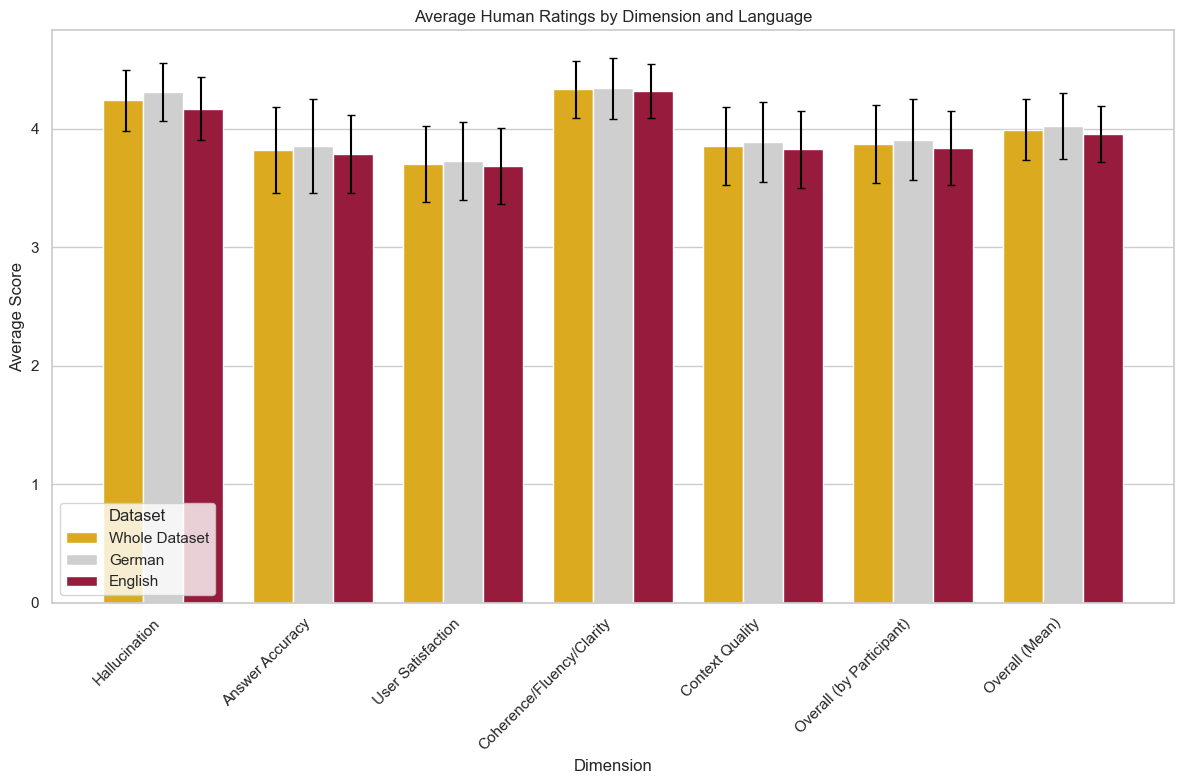

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Load the averaged human evaluations
df = pd.read_csv("../../../data/human_eval_avg.csv", encoding="utf-8")

# 2) Identify the columns corresponding to the averaged dimensions
dimensions = [
    "avg_hallucination",
    "avg_answer_acc",
    "avg_user_sat",
    "avg_coherence",
    "avg_context_qual",
    "avg_overall",
    "overall_mean"
]

# 3) Compute means and standard deviations
all_means = df[dimensions].mean().rename("Whole Dataset")
de_means  = df[df["langq"] == "de"][dimensions].mean().rename("German")
en_means  = df[df["langq"] == "en"][dimensions].mean().rename("English")

all_stds = df[dimensions].std().rename("Whole Dataset")
de_stds  = df[df["langq"] == "de"][dimensions].std().rename("German")
en_stds  = df[df["langq"] == "en"][dimensions].std().rename("English")

# Combine means into one DataFrame
mean_df = pd.concat([all_means, de_means, en_means], axis=1).transpose().reset_index()
mean_df = mean_df.rename(columns={"index": "Dataset"})

# Combine stds into one DataFrame
std_df = pd.concat([all_stds, de_stds, en_stds], axis=1).transpose().reset_index()
std_df = std_df.rename(columns={"index": "Dataset"})

# Reshape (melt) for plotting
melted_means = mean_df.melt(id_vars="Dataset", var_name="Dimension", value_name="Score")
melted_stds  = std_df.melt(id_vars="Dataset", var_name="Dimension", value_name="SD")

# Merge means & SD into one DataFrame
melted_df = pd.merge(melted_means, melted_stds, on=["Dataset", "Dimension"])

# --- Sort to ensure the data is in [Dimension1: Whole, German, English, Dimension2: Whole, ...] order
#     so the naive indexing approach will match the bar positions.
dimension_order = {
    "avg_hallucination": 0,
    "avg_answer_acc": 1,
    "avg_user_sat": 2,
    "avg_coherence": 3,
    "avg_context_qual": 4,
    "avg_overall": 5,
    "overall_mean": 6
}
dataset_order = {"Whole Dataset": 0, "German": 1, "English": 2}

# Create numeric sort keys
melted_df["dim_key"] = melted_df["Dimension"].map(dimension_order)
melted_df["set_key"] = melted_df["Dataset"].map(dataset_order)
melted_df = melted_df.sort_values(["dim_key", "set_key"]).reset_index(drop=True)

print(melted_df)
palette = {'Whole Dataset': '#fbb900', 'German': '#cfcfcf', 'English': '#ac0634'}

# 4) Plot using seaborn (without yerr)
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data=melted_df,
    x="Dimension",
    y="Score",
    hue="Dataset",
    ci=None,           # Turn off Seaborn's built-in confidence intervals
    palette=palette,
    dodge=True
)

# Manually add error bars
#
# 7 dimensions, each with 3 subsets => 21 rows total.
# i // 3 gives the dimension index (0..6).
# i % 3  gives the dataset index (0..2).
#
# The expression (i // 3) + ((i % 3) * 0.25) - 0.25 is a quick hack
# to shift each dataset's bar slightly so they don't overlap.
#
for i in range(len(melted_df)):
    x_pos = (i // 3) + (i % 3) * 0.25 - 0.25
    y_pos = melted_df.loc[i, "Score"]
    y_err = melted_df.loc[i, "SD"] * 0.45
    plt.errorbar(
        x=x_pos,
        y=y_pos,
        yerr=y_err,
        fmt='none',    # no marker
        c='black',
        capsize=3
    )

# Style the axes
plt.title("Average Human Ratings by Dimension and Language")
plt.xlabel("Dimension")
plt.ylabel("Average Score")
plt.xticks(rotation=45, ha="right")

# Adjust the x-tick labels if desired:
xtick_labels = {
    'avg_hallucination': 'Hallucination',
    'avg_answer_acc': 'Answer Accuracy',
    'avg_user_sat': 'User Satisfaction',
    'avg_coherence': 'Coherence/Fluency/Clarity',
    'avg_context_qual': 'Context Quality',
    'avg_overall': 'Overall (by Participant)',
    'overall_mean': 'Overall (Mean)'
}
current_ticks = plt.gca().get_xticks()
current_labels = plt.gca().get_xticklabels()
new_labels = []
for label in current_labels:
    raw_text = label.get_text()
    new_labels.append(xtick_labels.get(raw_text, raw_text))
plt.gca().set_xticklabels(new_labels)

plt.legend(title="Dataset")
plt.tight_layout()
# save the plot
plt.savefig("../../../data/figures/eval_survey/human_eval_avg.png")
plt.show()



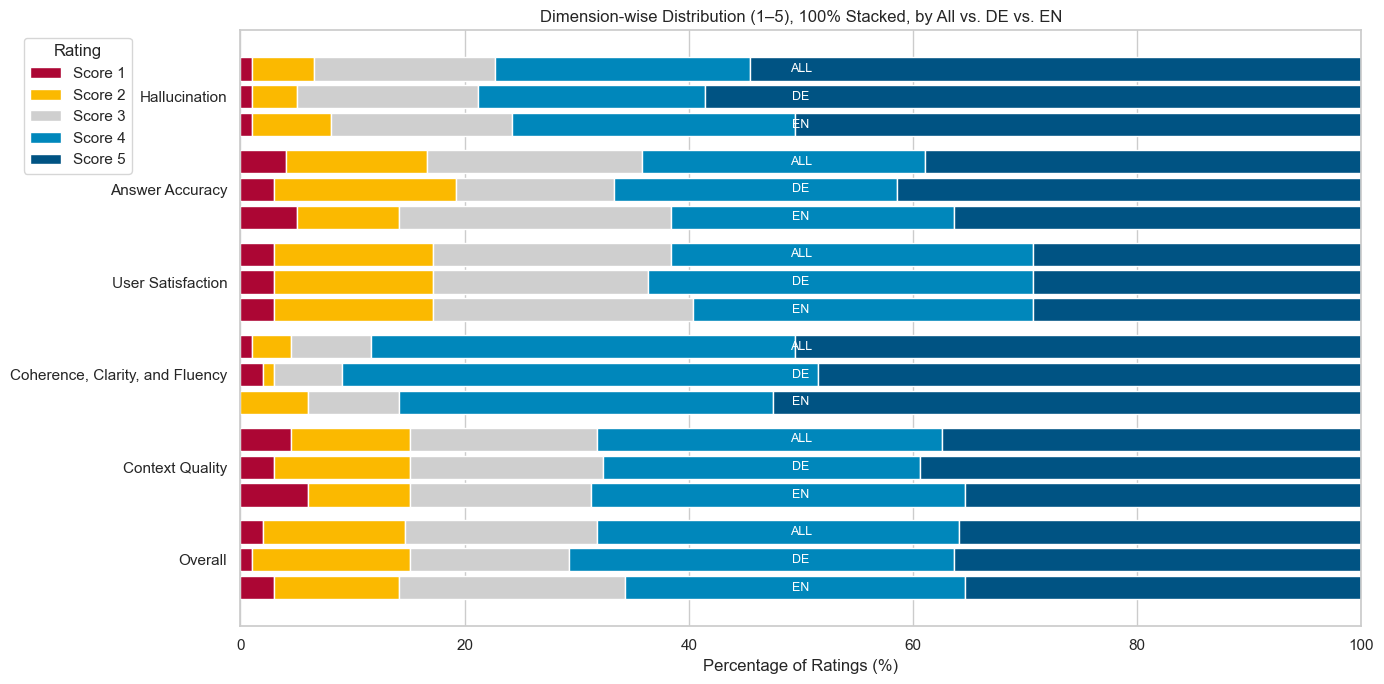

[Rating                1          2          3          4          5
Dimension                                                          
overall        3.030303  11.111111  20.202020  30.303030  35.353535
context_qual   6.060606   9.090909  16.161616  33.333333  35.353535
coherence      0.000000   6.060606   8.080808  33.333333  52.525253
user_sat       3.030303  14.141414  23.232323  30.303030  29.292929
answer_acc     5.050505   9.090909  24.242424  25.252525  36.363636
hallucination  1.010101   7.070707  16.161616  25.252525  50.505051, Rating                1          2          3          4          5
Dimension                                                          
overall        1.010101  14.141414  14.141414  34.343434  36.363636
context_qual   3.030303  12.121212  17.171717  28.282828  39.393939
coherence      2.020202   1.010101   6.060606  42.424242  48.484848
user_sat       3.030303  14.141414  19.191919  34.343434  29.292929
answer_acc     3.030303  16.161616  14.141414 

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1) Load or prepare your data
# -----------------------------
df_long = pd.read_csv("../../../data/human_eval/human_eval_long.csv", encoding="utf-8")

# Map ratings A1..A5 -> 1..5 if needed
rating_map = {'A1':1, 'A2':2, 'A3':3, 'A4':4, 'A5':5}
for dim in ["hallucination", "answer_acc", "user_sat", "coherence", "context_qual", "overall"]:
    df_long[dim] = df_long[dim].map(rating_map)

# Dimensions in a desired order
new_order = [
    "overall",
    "context_qual", 
    "coherence", 
    "user_sat", 
    "answer_acc", 
    "hallucination", 
]
# Labels for the y-axis
new_labels = [
    "Overall",
    "Context Quality",
    "Coherence, Clarity, and Fluency",
    "User Satisfaction",
    "Answer Accuracy",
    "Hallucination",
]

# -----------------------------
# 2) Melt data to long format
# -----------------------------
melted = df_long.melt(
    id_vars=['id','question_number','langq'], 
    value_vars=new_order,
    var_name="Dimension", 
    value_name="Rating"
)

# Function to get a 100%-stacked pivot (Dimension x Rating) 
def get_100pct_pivot(df, dims=new_order):
    # Count how many times each (Dimension, Rating) occurs
    counts = df.groupby(["Dimension","Rating"]).size().reset_index(name="Count")
    # Pivot -> row=Dimension, col=Rating
    pivot = counts.pivot(index="Dimension", columns="Rating", values="Count").fillna(0)
    # Convert to row-wise percentages
    row_sums = pivot.sum(axis=1)
    pivot_perc = pivot.div(row_sums, axis=0)*100
    # Reindex in the chosen dimension order
    pivot_perc = pivot_perc.reindex(dims)
    return pivot_perc

# -----------------------------
# 3) Subset the data
# -----------------------------
# Entire dataset
pivot_all = get_100pct_pivot(melted, new_order)
# German subset
pivot_de  = get_100pct_pivot(melted[melted['langq'] == 'de'], new_order)
# English subset
pivot_en  = get_100pct_pivot(melted[melted['langq'] == 'en'], new_order)

# We'll store them in a list in the order we want them to appear side by side:
group_data   = [pivot_en, pivot_de, pivot_all]
group_labels = ["EN", "DE", "ALL"]  # Just for clarity
# y-axis positions are 0..(n_dims-1)
dim_positions = np.arange(len(new_order))

# -----------------------------
# 4) Plot: grouped + stacked
# -----------------------------
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))

ratings = [1,2,3,4,5]
palette = ['#ac0634','#fbb900','#cfcfcf','#0087bb','#005383']

# Horizontal offset for each group’s bar
# e.g. if you have 3 groups, step them around 0 by +/- some offset
offsets = [-0.3, 0.0, 0.3]
bar_height = 0.25  # how "thick" each bar is

# only want each Rating color to appear once in the legend,
already_labeled_ratings = set()

for group_offset, pivot_df, group_name in zip(offsets, group_data, group_labels):
    # We'll keep track of where each stacked segment starts
    # for this group
    left_accum = np.zeros(len(new_order))  # all zeros initially
    
    for rating_idx, rating in enumerate(ratings):
        # Determine the label for the legend
        # We only add a label for the color if we haven't used it before
        if rating not in already_labeled_ratings:
            bar_label = f"Score {rating}"
            already_labeled_ratings.add(rating)
        else:
            bar_label = None
        
        plt.barh(
            y = dim_positions + group_offset,           # shift y by the offset
            width = pivot_df[rating],                  # the segment size for 'rating'
            left = left_accum,                         # start stacking at the current "left" edge
            height = bar_height,                       # thickness of each bar
            color = palette[rating_idx],               # color depends on rating
            label = bar_label,                         # only show rating label once
            edgecolor="white"
        )
        # Update left_accum so the next rating is stacked to the right of the current
        left_accum += pivot_df[rating].values
    

    for i, dim in enumerate(new_order):
        x_center = sum(pivot_df.loc[dim, ratings]) / 2 # roughly the midpoint in the stack
        y_pos = i + group_offset
        # This places text in the *middle* of the bar.
        plt.text(
            x_center, y_pos, group_name, 
            va='center', ha='center', color="white", fontsize=9
        )

# Cosmetics
plt.yticks(dim_positions, new_labels)  # new_labels for the dimension
plt.xlabel("Percentage of Ratings (%)")
plt.xlim(0, 100)
plt.title("Dimension-wise Distribution (1–5), 100% Stacked, by All vs. DE vs. EN")

# Build a legend that shows the rating colors
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, title="Rating", bbox_to_anchor=(-0.2, 1), loc="upper left")

plt.tight_layout()
plt.savefig("../../../data/figures/eval_survey/eval_surveycombined_stacked_distribution_all_de_en.png", bbox_inches="tight")
plt.show()
print(group_data)
